# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
</div>

## Setting up the environment

In [1]:
%pip install pyrosm keplergl haversine pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
import datetime
import numpy as np
import pandas as pd
import pyrosm
import random
import ssl
import time

from keplergl import KeplerGl
from pyrosm import OSM, get_data

In [3]:
# If you are using colab, you need to run this cell
# from google.colab import output
# output.enable_custom_widget_manager()

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [4]:
# Load the data
pasdaran_streets = pd.read_csv("datasets/pasdaran_streets.csv")
pasdaran_nodes = pd.read_csv("datasets/pasdaran_nodes.csv")

In [5]:
pasdaran_streets.head()

,street_id,u,v,length,oneway,u_lat,u_lon,v_lat,v_lon
0,5003747,423833948,423793584,90.570,no,35.772419,51.465652,35.771748,51.465084
1,17099043,177540293,423832815,296.273,yes,35.771034,51.464462,35.772175,51.461494
2,787945693,4429684144,423832815,62.573,no,35.772636,51.461891,35.772175,51.461494
3,687277053,177540293,423793585,97.898,no,35.771034,51.464462,35.770317,51.463833
4,36333153,9339973930,423793585,296.275,yes,35.771458,51.460865,35.770317,51.463833


In [6]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [7]:
# Visualize pasdaran_streets using kepler
visualized_map = KeplerGl(height=400, data = {"pasdaran_streets": pasdaran_streets})
visualized_map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'pasdaran_streets':        street_id            u            v   length oneway      u_lat  \
0 …

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [8]:
import heapq

def get_node_id(pos, graph):
    u_node = graph.loc[(graph["u_lat"] == pos[0]) & (graph["u_lon"] == pos[1])].to_numpy()
    v_node = graph.loc[(graph["v_lat"] == pos[0]) & (graph["v_lon"] == pos[1])].to_numpy()
    if len(u_node) > 0:
        return u_node[0][1]
    else:
        return v_node[0][2]

def get_neighbors(node, graph):
    nodes_to = graph.loc[(graph["u"] == node)].to_numpy()
    nodes_from = graph.loc[(graph["v"] == node)].to_numpy()
    return [(row[2], row[3]) for row in nodes_to] + [(row[1], row[3]) for row in nodes_from]

def backtrack(curr_node, parents):
    return [curr_node] if parents[curr_node] is None else backtrack(parents[curr_node], parents) + [curr_node]

def find_shortest_path(start_node, end_node, graph):
    """
    Find the shortest path between two nodes in a graph.
    :param start_node: The start node
    :param end_node: The end node
    :param graph: The graph
    :return: The shortest path. It is a list of node_ids from start_node to end_node.
    Note that you use all of the data in "pasdaran_streets" dataset appropriately such as "street_length" and "one_way".
    """
    start_node_id = get_node_id(start_node, graph)
    end_node_id = get_node_id(end_node, graph)
    heap = []
    costs = {}
    parents = {}
    route = []
    
    heapq.heappush(heap, (0, start_node_id))
    costs[start_node_id] = 0
    parents[start_node_id] = None
    
    while heap:
        _, curr_node = heapq.heappop(heap)
        if curr_node == end_node_id:
            route = backtrack(curr_node, parents)
            break
        for neighbor, distance in get_neighbors(curr_node, graph):
            if neighbor not in costs or costs[neighbor] > costs[curr_node] + distance:
                costs[neighbor] = costs[curr_node] + distance
                parents[neighbor] = curr_node
                heapq.heappush(heap, (costs[neighbor], neighbor))
    
    return route

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [9]:
# Create a trip: Choose 2 random points as start and end points and find the shortest path between them.
# A trip is a list of node_ids from start_node to end_node.

possible_nodes = [(row[0], row[1]) for row in pasdaran_streets[["u_lat", "u_lon"]].to_numpy()]
for row in pasdaran_streets[["v_lat", "v_lon"]].to_numpy():
    possible_nodes.append((row[0], row[1]))

random_nodes = np.random.choice(len(possible_nodes), 2, replace=False)
start_node = possible_nodes[random_nodes[0]]
end_node = possible_nodes[random_nodes[1]]

trip = find_shortest_path(start_node, end_node, pasdaran_streets)
trip

[4379726016,
 4695667393,
 806589358,
 4695818010,
 4695818011,
 423832591,
 4695882306,
 423832592,
 4695924440,
 4695924438,
 4695969091,
 4695924428,
 4695969093,
 423832593,
 4316456836,
 4316456842,
 4695969096]

Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [10]:
trip_df = pasdaran_nodes.loc[pasdaran_nodes["id"].isin(trip)]
visualized_trip = KeplerGl(height=400, data = {"trip": trip_df})
visualized_trip

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'trip':               id        lat        lon
5     4316456842  35.774864  51.456291
6     431…

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [11]:
def get_street_distance(id1, id2):
    street = pasdaran_streets.loc[(pasdaran_streets["u"] == id1) & (pasdaran_streets["v"] == id2)].to_numpy()
    if len(street) > 0:
        return street[0][3]
    else:
        return pasdaran_streets.loc[(pasdaran_streets["u"] == id2) & (pasdaran_streets["v"] == id1)].to_numpy()[0][3]

def get_lat_lon(id):
    node = pasdaran_streets.loc[pasdaran_streets["u"] == id].to_numpy()
    if len(node) > 0:
        return (node[0][5], node[0][6])
    else:
        node = pasdaran_streets.loc[(pasdaran_streets["v"] == id)].to_numpy()[0]
        return (node[7], node[8])

def visualize_a_ride(ride_speed, ride_gps_time, trip):
    remaining_time = ride_gps_time
    street_dist = get_street_distance(trip[0], trip[1])
    lat1, lon1 = get_lat_lon(trip[0])
    lat2, lon2 = get_lat_lon(trip[1])
    ride = [(lat1, lon1)]
    i = 2
    while (i <= len(trip)):
        if (ride_speed * remaining_time) <= street_dist:
            node_mid = (lat1 + (lat2 - lat1) * (ride_speed * remaining_time) / street_dist, lon1 + (lon2 - lon1) * (ride_speed * remaining_time) / street_dist)
            ride.append(node_mid)
            lat1, lon1 = node_mid
            street_dist -= ride_speed * remaining_time
            remaining_time = ride_gps_time
        else:
            ride.append((lat2, lon2))
            if (i == len(trip)):
                break
            lat1, lon1 = lat2, lon2
            lat2, lon2 = get_lat_lon(trip[i])
            remaining_time -= street_dist / ride_speed
            street_dist = get_street_distance(trip[i-1], trip[i])
            i += 1
    
    return ride    

See a sample ride, printed out.

In [12]:
ride = visualize_a_ride(ride_speed=10, ride_gps_time=20, trip=trip)
ride

[(35.76731872558594, 51.4515495300293),
 (35.76698684692383, 51.45262908935547),
 (35.76752853393555, 51.45288848876953),
 (35.76779080115538, 51.453012085965085),
 (35.767860412597656, 51.45304489135742),
 (35.76814651489258, 51.45318222045898),
 (35.768798828125, 51.4534912109375),
 (35.76935958862305, 51.453758239746094),
 (35.76946886715265, 51.45381004060753),
 (35.77053451538086, 51.45431518554688),
 (35.77115054901666, 51.45459626553279),
 (35.77153778076172, 51.45477294921875),
 (35.77192687988281, 51.45495223999024),
 (35.77205276489258, 51.45500946044922),
 (35.772605895996094, 51.45526123046875),
 (35.77283681984378, 51.45536752874785),
 (35.77308654785156, 51.45548248291016),
 (35.77321243286133, 51.45553970336914),
 (35.77397537231445, 51.45588684082031),
 (35.774523836488, 51.456136356710424),
 (35.774864196777344, 51.45629119873047),
 (35.774658203125, 51.45696258544922)]

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

In [13]:
ride_df = pd.DataFrame(ride, columns=["lat", "lon"])
visualized_ride = KeplerGl(height=400, data = {"ride": ride_df})
visualized_ride

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride':           lat        lon
0   35.767319  51.451550
1   35.766987  51.452629
2   35.76752…

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [14]:
# put a random noise on each (lat, lon) location to simulate the GPS noise (suppose GPS radius is 3 - 8 meters)
# Print out a sample
def add_normal_noise(pos, gps_noise_radius):
    noise_lat = np.random.normal(loc=0, scale=gps_noise_radius) 
    noise_lon = np.random.normal(loc=0, scale=gps_noise_radius)
    
    return pos[0] + noise_lat / 111000, pos[1] + noise_lon / 111000

noisy_ride = [add_normal_noise(pos, 5) for pos in ride]
noisy_ride

[(35.76731264277909, 51.451519556165195),
 (35.76703401719497, 51.45268603378905),
 (35.76747170558883, 51.45278789084566),
 (35.76779761541302, 51.452986823535916),
 (35.767767398185505, 51.45305248059718),
 (35.76809401558752, 51.45315982413787),
 (35.76882664191779, 51.45344619096785),
 (35.76938112920629, 51.453880833848864),
 (35.769425238028056, 51.453734191221486),
 (35.770615813093826, 51.45426632585004),
 (35.77116354436003, 51.45462019106658),
 (35.77152035143293, 51.45479980868114),
 (35.77190391303135, 51.45491327396017),
 (35.772066604340644, 51.45510005498924),
 (35.77254815771782, 51.455218027744756),
 (35.77277675660455, 51.45525735675372),
 (35.7731809294132, 51.455454393261796),
 (35.77321069064778, 51.45559726065071),
 (35.77393122552434, 51.45586679877067),
 (35.77448369926593, 51.45626131131975),
 (35.77487666394436, 51.45629498289904),
 (35.7745821706526, 51.45689669493934)]

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [15]:
def add_normal_noise(pos, gps_noise_radius):
    noise_lat = np.random.normal(loc=0, scale=gps_noise_radius) 
    noise_lon = np.random.normal(loc=0, scale=gps_noise_radius)
    return pos[0] + noise_lat / 111000, pos[1] + noise_lon / 111000

def add_uniform_noise(pos, gps_noise_radius):
    noise_lat = np.random.uniform(low=-gps_noise_radius, high=gps_noise_radius) 
    noise_lon = np.random.uniform(low=-gps_noise_radius, high=gps_noise_radius)
    return pos[0] + noise_lat / 111000, pos[1] + noise_lon / 111000

def add_speed_dependent_noise(pos, gps_noise_radius, speed):
    gps_noise_radius += speed / 10
    noise_lat = np.random.normal(loc=0, scale=gps_noise_radius) 
    noise_lon = np.random.normal(loc=0, scale=gps_noise_radius)
    return pos[0] + noise_lat / 111000, pos[1] + noise_lon / 111000

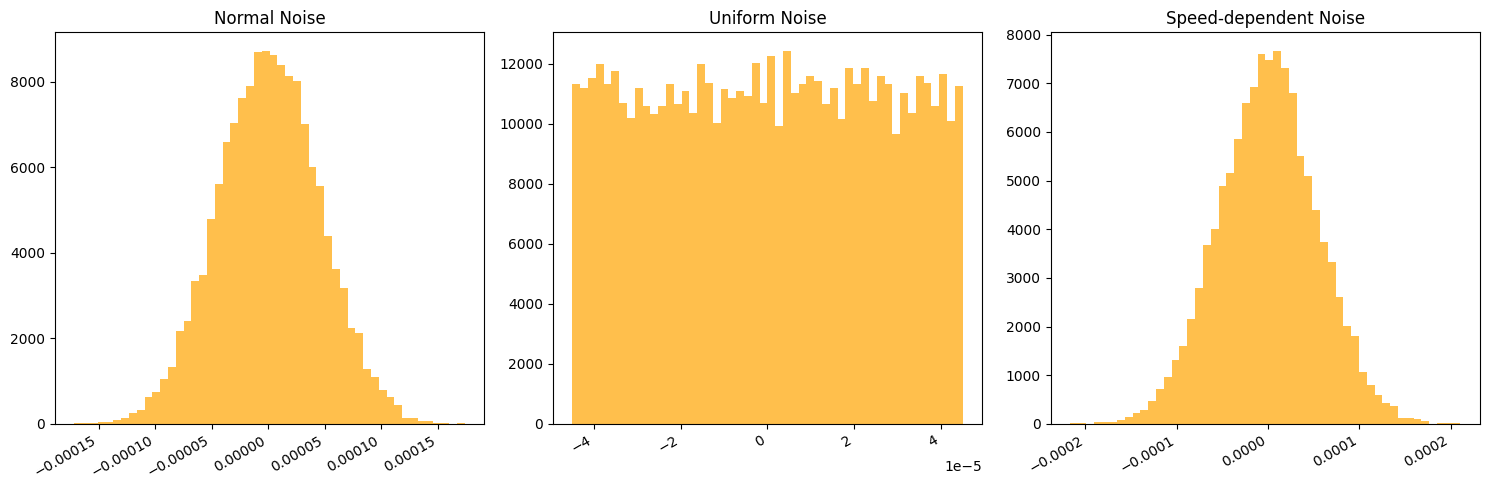

In [16]:
import matplotlib.pyplot as plt

num_samples = 10000
normal_samples = [add_normal_noise((0, 0), 5)[0] for _ in range(num_samples)]
uniform_samples = [add_uniform_noise((0, 0), 5)[0] for _ in range(num_samples)]
speed_dependent_samples = [add_speed_dependent_noise((0, 0), 5, 10)[0] for _ in range(num_samples)]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].hist(normal_samples, bins=50, density=True, alpha=0.7, color='orange')
axes[0].set_title("Normal Noise")
plt.setp(axes.flatten()[0].get_xticklabels(), rotation=30, horizontalalignment='right')

axes[1].hist(uniform_samples, bins=50, density=True, alpha=0.7, color='orange')
axes[1].set_title("Uniform Noise")
plt.setp(axes.flatten()[1].get_xticklabels(), rotation=30, horizontalalignment='right')

axes[2].hist(speed_dependent_samples, bins=50, density=True, alpha=0.7, color='orange')
axes[2].set_title("Speed-dependent Noise")
plt.setp(axes.flatten()[2].get_xticklabels(), rotation=30, horizontalalignment='right')

fig.tight_layout()

In [17]:
noisy_ride_normal = [add_normal_noise(pos, 5) for pos in ride]
noisy_ride_uniform = [add_uniform_noise(pos, 5) for pos in ride]
noisy_ride_speed_dependent = [add_speed_dependent_noise(pos, 5, speed=10) for pos in ride]

noisy_ride_normal_df = pd.DataFrame(noisy_ride_normal, columns=["lat", "lon"])
noisy_ride_uniform_df = pd.DataFrame(noisy_ride_uniform, columns=["lat", "lon"])
noisy_ride_speed_dependent_df = pd.DataFrame(noisy_ride_speed_dependent, columns=["lat", "lon"])

visualized_noisy_rides = KeplerGl(height=400, data = {"noisy_ride_normal_df": noisy_ride_normal_df,
                                                      "noisy_ride_uniform_df": noisy_ride_uniform_df,
                                                      "noisy_ride_speed_dependent_df": noisy_ride_speed_dependent_df})
visualized_noisy_rides

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'noisy_ride_normal_df':           lat        lon
0   35.767275  51.451571
1   35.767088  51.452…

In [18]:
noise_model = add_speed_dependent_noise

**Explanation of my noise model:**

I think the normal dist. with speed dependency is the best model and is the closest one to the real world.
First of all, our noise dist. should have more points near the real GPS location, so the uniform dist. is not a good approximation.
Also the faster the driver rides, the noisier its GPS location gets, so we should put the effects of ride_speed in our distribution.
So overall the normal dist. which is speed dependent would be a good approximation.

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [19]:
ride = visualize_a_ride(ride_speed=10, ride_gps_time=20, trip=trip)
noisy_ride = [noise_model(pos, 5, 10) for pos in ride]

ride_df = pd.DataFrame(ride, columns=["lat", "lon"])
noisy_ride_df = pd.DataFrame(noisy_ride, columns=["lat", "lon"])

visualized_ride_vs_noisy_ride = KeplerGl(height=400, data = {"ride": ride_df,
                                                      "noisy_ride": noisy_ride_df})
visualized_ride_vs_noisy_ride

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride':           lat        lon
0   35.767319  51.451550
1   35.766987  51.452629
2   35.76752…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [20]:
possible_nodes = [(row[0], row[1]) for row in pasdaran_streets[["u_lat", "u_lon"]].to_numpy()]
for row in pasdaran_streets[["v_lat", "v_lon"]].to_numpy():
    possible_nodes.append((row[0], row[1]))

random_nodes = np.random.choice(len(possible_nodes), 40, replace=False)
start_nodes = [possible_nodes[random_nodes[i * 2]] for i in range(20)]
end_nodes = [possible_nodes[random_nodes[i * 2 + 1]] for i in range(20)]

trips = [find_shortest_path(start_nodes[i], end_nodes[i], pasdaran_streets) for i in range(20)]
rides = [visualize_a_ride(ride_speed=np.random.randint(1, 20), ride_gps_time=np.random.randint(10, 20), trip=trips[i]) for i in range(20)]
noisy_rides = [[noise_model(pos, 5, 10) for pos in ride] for ride in rides]

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [21]:
def calc_distance_between_point_line(point, u, v):
    if np.dot(v - u, point - u) < 0:
        return np.linalg.norm(point - u)
    elif np.dot(v - u, point - v) > 0:
        return np.linalg.norm(point - v)
    return abs(np.cross(v - u, point - u)) / np.linalg.norm(v - u)

def normal_speed_dependent_pdf(x, mean, std, speed):
    std += speed / 10
    return np.exp(-((x - mean) ** 2) / (2 * (std ** 2))) / (std * np.sqrt(2 * np.pi))

In [22]:
# Define your HMM model
# Hint: You can assume states of your HMM model to be streets of the map. You may use other designs as well (based on your creativity)!

class HMM:
    def __init__(self, pasdaran_streets, observations):
        self.states = pasdaran_streets
        self.num_states = len(pasdaran_streets)
        self.observations = observations
        self.num_observations = len(observations)
        self.transition_matrix = np.zeros((self.num_states, self.num_states))
        self.emission_matrix = np.zeros((self.num_states, len(observations)))
        self.build_emissions_matrix()
    
    def build_emissions_matrix(self):
        for i in range(self.num_states):
            for j in range(self.num_observations):
                street = self.states.to_numpy()[i]
                u, v = (street[5], street[6]), (street[7], street[8])
                distance = calc_distance_between_point_line(np.array(self.observations[j]), np.array(u), np.array(v))
                prob = normal_speed_dependent_pdf(distance, 0, 5, 10)
                self.emission_matrix[i][j] = prob
    
    def get_points_along_street(self, point, state):
        street = self.states.to_numpy()[state]
        u, v = (street[5], street[6]), (street[7], street[8])
        
        if u[0] == v[0]:
            return u[0], point[1] 
        elif u[1] == v[1]:
            return point[0], u[1]
        else:
            a1 = (u[1] - v[1]) / (u[0] - v[0])
            b1 = u[1] - a1 * u[0]
            a2 = -1 / a1
            b2 = point[1] - a2 * point[0]
            project_x = (b2 - b1) / (a1 - a2)
            project_y = a1 * project_x + b1
            return project_x, project_y

In [23]:
# Use Viterbi Algorithm to find the most probable set of points (denoised points)

def viterbi(hmm):
    num_states = hmm.num_states
    num_observations = hmm.num_observations
    
    m = np.zeros((num_states, num_observations))
    backtrack = np.zeros((num_states, num_observations), dtype=int)
    
    for i in range(num_states):
        m[i, 0] = hmm.emission_matrix[i, 0] / num_states
        
    for i in range(1, num_observations):
        for j in range(num_states):
            prev_m = [m[k, i - 1] * 1 / num_samples for k in range(num_states)]
            m[j, i] = np.max(prev_m) * hmm.emission_matrix[j, i]
            backtrack[j, i] = np.argmax(prev_m)
            
    best_path = []
    curr_state = np.argmax(m[:, -1])
    for i in range(num_observations):
        best_path.append(curr_state)
        curr_state = backtrack[curr_state, num_observations - 1 - i]

    nodes = []    
    for i, state in enumerate(best_path[::-1]):
        nodes.append(hmm.get_points_along_street(hmm.observations[i], state))
        
    return nodes

Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [25]:
hmm = HMM(pasdaran_streets, noisy_rides[0])
denoised = viterbi(hmm)

noisy_ride_df = pd.DataFrame(noisy_rides[0], columns=["lat", "lon"])
denoised_ride_df = pd.DataFrame(denoised, columns=["lat", "lon"])

visualized_denoised_ride = KeplerGl(height=400, data = {"noisy_ride_df": noisy_ride_df,
                                                      "denoised_ride_df": denoised_ride_df})
visualized_denoised_ride

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'noisy_ride_df':           lat        lon
0   35.779445  51.458259
1   35.779798  51.457303
2  …

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [28]:
from haversine import haversine
from tqdm import tqdm

def mean_haversine_distance(denoised_points, original_points):
    distance = sum([haversine(denoised_points[i], original_points[i]) for i in range(len(denoised_points))])
    return distance / len(denoised_points)

test_dataset_noisy = pd.read_csv("datasets/noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("datasets/original_test_dataset.csv")

test_dataset_original.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771816,51.461178,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771458,51.460865,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770760,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.770027,51.459633,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769318,51.459030,0.00096,0.466


In [29]:
test_dataset_noisy.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771917,51.461279,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771399,51.460806,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770759,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.769997,51.459603,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769289,51.459002,0.00096,0.466


In [30]:
# Iterate through each noisy ride and denoise it, then calculate the mean haversine distance between the denoised ride and the original ride
# Report the Average Mean Haversine Distance for all the rides in the test dataset
# This should be of order 10^-3
test_dataset_denoised = test_dataset_noisy.copy(deep=True)

for i in tqdm(test_dataset_noisy.trip_id.unique()):
    trip_obs = test_dataset_noisy.loc[test_dataset_noisy["trip_id"] == i].sort_values("index")
    observation = [(row[0], row[1]) for row in trip_obs[["lat", "lon"]].to_numpy()]
    hmm = HMM(pasdaran_streets, observation)
    denoised = viterbi(hmm)
    for j in range(len(denoised)):
        test_dataset_denoised.loc[(test_dataset_denoised["trip_id"] == i) & (test_dataset_denoised["index"] == j), ["lat", "lon"]] = denoised[j]
    
noisy_nodes = [(row[0], row[1]) for row in test_dataset_denoised[["lat", "lon"]].to_numpy()]
original_nodes = [(row[0], row[1]) for row in test_dataset_original[["lat", "lon"]].to_numpy()]
print(mean_haversine_distance(noisy_nodes, original_nodes))

test_dataset_denoised.to_csv("denoised_test_dataset.csv", index=False)

100%|██████████| 19/19 [05:42<00:00, 18.04s/it]

0.007975417463559046
